# CSE711 Project
# Title: A Data Driven Machine Learning based Forecasting Approach for Posterior Product Demand Explained with Explainable AI
# Members:
- Adria Binte Habib ID: 22366041
- Hasnat Md. Abdullah ID: 22166025
- Md Jahid Hasan   ID: 22166035


## Data loading


In [1]:
 # Imports
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from pathlib import Path
import xgboost as xgb
# color_pal= sns.color_palette()
plt.style.use('fivethirtyeight')
#LR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from math import sqrt

#RF
from sklearn.ensemble import RandomForestRegressor

#KNN
from sklearn import neighbors

#xgboost
import xgboost as xgb

In [2]:
def load_data(path,date=None):
    
    data= pd.read_csv(path)
    data['date']=pd.to_datetime(data['date'])
    
    if date!=None:
        train_set=data.loc[data['date'] < date]
        test_set=data.loc[data['date'] >= date]
        return (train_set,test_set)
    print("Data loading...Done.")
    return data

In [3]:
KAGGLE_DATA_PATH= "E:\\Documents\\jupyter_workspace\\CSE711\\Data\\train.csv"
df = load_data(KAGGLE_DATA_PATH)
train_set, test_set = load_data(KAGGLE_DATA_PATH,"2017-01-01")
train_set.head()

Data loading...Done.


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
test_set.head()

,date,store,item,sales
1461,2017-01-01,1,1,19
1462,2017-01-02,1,1,15
1463,2017-01-03,1,1,10
1464,2017-01-04,1,1,16
1465,2017-01-05,1,1,14


## Sales (Yearly) Visualization

In [5]:
def plot_sales_yearly(df,st_date, en_date):
    df_temp = df.copy()
    df_temp['date'] = pd.to_datetime(df_temp['date'])
    df_temp = pd.DataFrame(df_temp)
    # df_temp.plot(figsize= (15,5))
    df_temp.set_index('date', inplace=True)
    ax = df_temp.loc[(df_temp.index >st_date) & (df_temp.index < en_date)]['sales'].plot(figsize=(15,7), title='Sales Visualization over time')
    
    ax.set_xlabel("Dates")
    ax.set_ylabel("Sales")
    
    fig = ax.get_figure()
    fig.savefig("sales_viz.png")
    print("plotting yearly sales")
    

plotting yearly sales


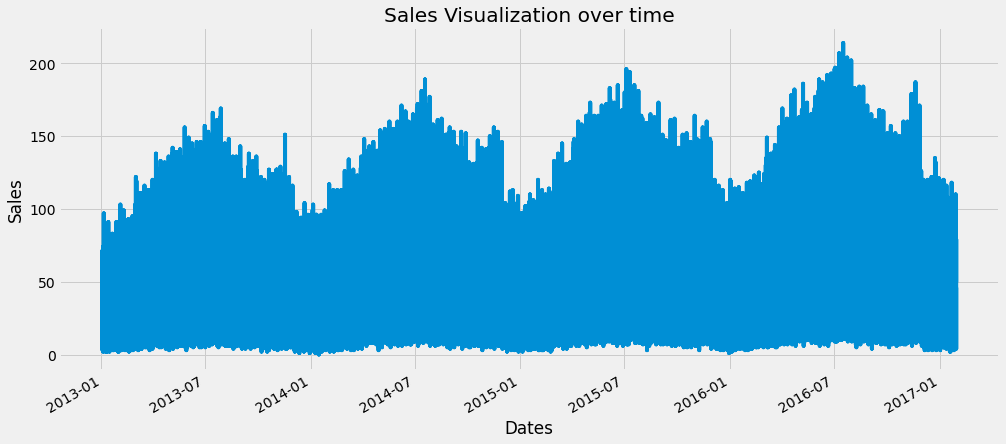

In [6]:
#%% data visualization
plot_sales_yearly(df,'2013-01-01','2017-01-31')





## Sales (Monthly) Visualization

In [7]:
def plot_sales_monthly(df):
    print("plotting monthly sales")
    df_temp = df.copy()
    df_temp['date'] = pd.to_datetime(df_temp['date'])
    df_temp = pd.DataFrame(df_temp)
    df_temp.set_index('date', inplace=True)
    
    df_temp['month'] = df_temp.index.month




    fig, ax=plt.subplots(figsize=(13,9))
    sns.boxplot(data=df_temp, x='month',y='sales')
    ax.set_title('Sales Visualization by Months')
    
    plt.show()
    # fig.savefig("figures/sales_viz_by_months.png")
    

plotting monthly sales


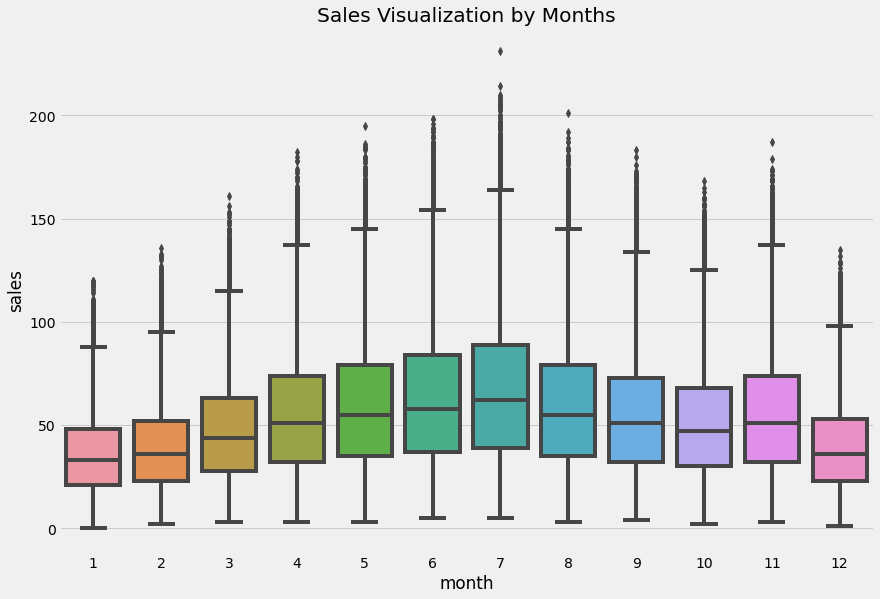

In [8]:
plot_sales_monthly(df)

## Feature Extraction

In [9]:
def date_features(df):
    # Date Features
    df = df.copy()
    
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['dayofyear'] = df.date.dt.dayofyear
    df['dayofweek'] = df.date.dt.dayofweek
    df['weekofyear'] = df.date.dt.weekofyear
    
    # Additionnal Data Features
    df['day^year'] = np.log((np.log(df['dayofyear'] + 1)) ** (df['year'] - 2000))
    
    df['daily_avg'] = df.groupby(['item','store','dayofweek'])['sales'].transform('mean')
    df['monthly_avg'] = df.groupby(['item','store','month'])['sales'].transform('mean')
    
    df = df.dropna()
    # Drop date
    df.drop('date', axis=1, inplace=True)
    print("date feature generation... Done.")
    return df
# Dates Features for Train, Test
train_set, test_set = date_features(train_set), date_features(test_set)

C:\Users\hasna\AppData\Local\Temp\ipykernel_25624\3448447598.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df.date.dt.weekofyear


date feature generation... Done.
date feature generation... Done.


C:\Users\hasna\AppData\Local\Temp\ipykernel_25624\3448447598.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df.date.dt.weekofyear


In [10]:
train_set.head()

,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg
0,1,1,13,2013,1,1,1,1,1,-4.764668,17.765550,13.225806
1,1,1,11,2013,1,2,2,2,1,1.222622,18.291866,13.225806
2,1,1,14,2013,1,3,3,3,1,4.246245,18.703349,13.225806
3,1,1,13,2013,1,4,4,4,1,6.186505,20.602871,13.225806
4,1,1,10,2013,1,5,5,5,1,7.581575,22.200957,13.225806


In [11]:
test_set.head()

,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg
1461,1,1,19,2017,1,1,1,6,52,-6.230720,26.301887,15.645161
1462,1,1,15,2017,1,2,2,0,1,1.598813,17.096154,15.645161
1463,1,1,10,2017,1,3,3,1,1,5.552782,19.788462,15.645161
1464,1,1,16,2017,1,4,4,2,1,8.090045,20.807692,15.645161
1465,1,1,14,2017,1,5,5,3,1,9.914367,22.461538,15.645161


## correlation matrix

In [12]:
def plot_corr_matrix(df):
    sns.set(rc = {'figure.figsize':(15,5)})
    temp = sns.heatmap(df.corr(),cmap= "YlGnBu", annot = True)
    #sales has positive corr. with daily_avg and monthly_avg
    print("plotting correlation matrix")
    fig = temp.get_figure()
    # fig.savefig("corr_matix.png")

plotting correlation matrix


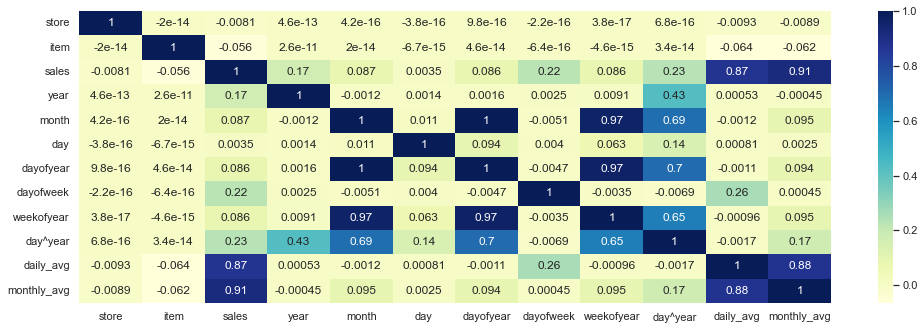

In [13]:
#%% correlation matrix of trainset
plot_corr_matrix(train_set)

## Clean features


In [14]:
def clean_features(train_set,test_set,remove_features):
    # dropping low corr. features
    for df in [train_set, test_set]:
        df.drop(remove_features,
                     axis=1, 
                     inplace=True)
    print("Clearing unnecessary features... Done.")
    return (train_set,test_set)

In [15]:
#%% clean features
remove_features =['dayofyear', 
              'weekofyear',
              'day',
              'month',
              'item',
              'store']
train_set, test_set = clean_features(train_set, test_set,remove_features)
print(train_set.columns)

Clearing unnecessary features... Done.
Index(['sales', 'year', 'dayofweek', 'day^year', 'daily_avg', 'monthly_avg'], dtype='object')


In [16]:
def scale_features(train_set,test_set):
    # Features Scaling (except sales)
    train_sales_series, test_sales_series = train_set['sales'], test_set['sales']
    # Features Scaling
    train_set = (train_set - train_set.mean()) / train_set.std()
    test_set = (test_set - test_set.mean()) / test_set.std()
    
    # Retrieve actual Sales values and ID
    train_set['sales'] = train_sales_series
    test_set['sales'] = test_sales_series
    
    print("Scaling features... Done.")
    return (train_set,test_set)

In [17]:
#%% feature scaling
train_set, test_set = scale_features(train_set, test_set)
print(train_set.head())

Scaling features... Done.
   sales      year  dayofweek  day^year  daily_avg  monthly_avg
0     13 -1.342191  -1.000856 -6.676446  -1.351328    -1.470683
1     11 -1.342191  -0.500428 -5.223511  -1.329674    -1.470683
2     14 -1.342191   0.000000 -4.489769  -1.312744    -1.470683
3     13 -1.342191   0.500428 -4.018927  -1.234592    -1.470683
4     10 -1.342191   1.000856 -3.680385  -1.168842    -1.470683


In [18]:
train_set.head()

,sales,year,dayofweek,day^year,daily_avg,monthly_avg
0,13,-1.342191,-1.000856,-6.676446,-1.351328,-1.470683
1,11,-1.342191,-0.500428,-5.223511,-1.329674,-1.470683
2,14,-1.342191,0.000000,-4.489769,-1.312744,-1.470683
3,13,-1.342191,0.500428,-4.018927,-1.234592,-1.470683
4,10,-1.342191,1.000856,-3.680385,-1.168842,-1.470683


In [19]:
test_set.head()

,sales,year,dayofweek,day^year,daily_avg,monthly_avg
1461,19,0.0,1.493344,-7.549409,-1.152154,-1.462102
1462,15,0.0,-1.501549,-5.752584,-1.478373,-1.462102
1463,10,0.0,-1.002400,-4.845175,-1.382967,-1.462102
1464,16,0.0,-0.503251,-4.262891,-1.346849,-1.462102
1465,14,0.0,-0.004103,-3.844221,-1.288242,-1.462102


In [20]:
#%% Separating X_train,y_train, X_test, y_test
# Training Data
X_train = train_set.drop('sales', axis=1).dropna()
y_train = train_set['sales']

X_test = test_set.drop('sales',axis = 1).dropna()
y_test = test_set['sales']


In [21]:
X_t = X_train.copy()
y_t = y_train.copy()

X_tst = X_test.copy()
y_tst = y_test.copy()
X_t.head()

,year,dayofweek,day^year,daily_avg,monthly_avg
0,-1.342191,-1.000856,-6.676446,-1.351328,-1.470683
1,-1.342191,-0.500428,-5.223511,-1.329674,-1.470683
2,-1.342191,0.000000,-4.489769,-1.312744,-1.470683
3,-1.342191,0.500428,-4.018927,-1.234592,-1.470683
4,-1.342191,1.000856,-3.680385,-1.168842,-1.470683


In [22]:
def print_performance_metrics(model, X_test,y_test,model_name):
    pred= model.predict(X_test)
    error=sqrt(mean_squared_error(y_test,pred))
    r_squared_score = r2_score(y_test,pred)
    error_mae = mean_absolute_error(y_test, pred)
    print(f"***** Performance metrics of Model: {model_name} *****")
    print("rmse score: ", error)
    print("r2 score: ",r_squared_score)
    print("mean absolute error: ",error_mae)
    print("*******************************************************")

## Training: Logistic Regression


|metric       |Values      
|----------------------|:-----------|
|R-squared score|0.8189701553783529|
|RMSE|13.424879377535198|
|mean absolute error|10.472208219178082|


In [34]:
#%% Train: Logistic Regression (LR)
def train_lr (X_t,y_t):
    
    lr = LogisticRegression(verbose = 5,n_jobs = -1)
    lr.fit(X_t, y_t)
    print("logistic regression training... Done.")
    return lr
# lr = train_lr(X_t, y_t)

# save the model to disk
# filename = 'models/lr_model.sav'
# pickle.dump(lr, open(filename, 'wb'))

# load the model from disk
# lr = pickle.load(open('../models/lr_model.sav', 'rb'))

# print performance metrics
# print_performance_metrics(lr, X_tst, y_tst,"logistic regression")

***** Performance metrics of Model: logistic regression *****
rmse score:  13.424879377535198
r2 score:  0.8189701553783529
mean absolute error:  10.472208219178082
*******************************************************


In [40]:
# pred= lr.predict(X_tst)
# error=sqrt(mean_squared_error(y_tst,pred))
# print("rmse score: ", error)
# print("r2 score: ",r2_score(y_tst,pred))

rmse score:  13.424879377535198
r2 score:  0.8189701553783529


In [41]:
# test_set['lr_predictions'] = lr.predict(X_tst)
# test_set.head()

,sales,year,dayofweek,day^year,daily_avg,monthly_avg,xgb_predictions,knn_predictions,rf_predictions,lr_predictions
1461,19,0.0,1.493344,-7.549409,-1.152154,-1.462102,16.542448,15.50,17.574207,6
1462,15,0.0,-1.501549,-5.752584,-1.478373,-1.462102,10.982952,10.90,14.428444,6
1463,10,0.0,-1.002400,-4.845175,-1.382967,-1.462102,12.597610,11.35,14.696772,9
1464,16,0.0,-0.503251,-4.262891,-1.346849,-1.462102,12.647338,12.80,14.795627,9
1465,14,0.0,-0.004103,-3.844221,-1.288242,-1.462102,13.972856,13.15,15.493315,11


## Training Random forest

|metric       |Values      
|----------------------|:-----------|
|R-squared score|0.8480236401430762|
|RMSE|12.300515765391212|
|mean absolute error|9.076153218562636|



In [85]:

from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
X_t = X_train.copy()
y_t = y_train.copy()

X_tst = X_test.copy()
y_tst = y_test.copy()


rmse_val_rf = []
for n in range(5,55,5):
    
    model_rf = RandomForestRegressor(n_estimators = n, max_features = 'sqrt', max_depth = 5, random_state = 18)
    model_rf.fit(X_t,y_t)
    pred = model_rf.predict(X_tst)
    #rmse
    error=sqrt(mean_squared_error(y_tst,pred))
    rmse_val_rf.append(error) 
    print('RMSE value for estimator n =',n,'is:',error)
    





RMSE value for estimator n = 5 is: 12.38312019402695
RMSE value for estimator n = 10 is: 12.54969995333348
RMSE value for estimator n = 15 is: 12.326091022379673
RMSE value for estimator n = 20 is: 12.421165686203874
RMSE value for estimator n = 25 is: 12.358945635964236
RMSE value for estimator n = 30 is: 12.367043268634772
RMSE value for estimator n = 35 is: 12.407614914165107
RMSE value for estimator n = 40 is: 12.308896049069434
RMSE value for estimator n = 45 is: 12.300515765391212
RMSE value for estimator n = 50 is: 12.309381709389255


<AxesSubplot:>

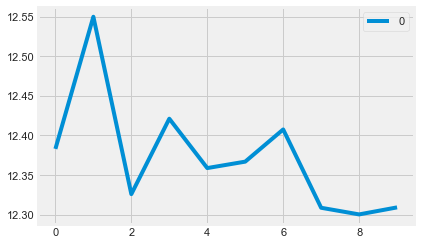

In [86]:
#plotting the rmse values against k values
curve_rf= pd.DataFrame(rmse_val_rf)

curve_rf.plot()

In [24]:
#%%  Train: Random Forest
# we are choosing n estimator = 45 
def train_rf(X_t,y_t):
    model_rf = RandomForestRegressor(n_estimators = 45, max_features = 'sqrt', max_depth = 5, random_state = 18)
    model_rf.fit(X_t,y_t)
    print("Random Forest training... Done.")
    return model_rf

model_rf = train_rf(X_t, y_t)

#save model
# joblib.dump(model_rf, "models/random_forest.joblib")
#load model
# model_rf = joblib.load("models/random_forest.joblib")
# pred = model_rf.predict(X_tst)

#print performance metrics
print_performance_metrics(model_rf,X_tst, y_tst,"Random Forest")

Random Forest training... Done.
***** Performance metrics of Model: Random Forest *****
rmse score:  12.300515765391212
r2 score:  0.8480236401430762
mean absolute error:  9.076153218562636
*******************************************************


In [34]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
X_t = X_train.copy()
y_t = y_train.copy()

X_tst = X_test.copy()
y_tst = y_test.copy()


pred = model_rf.predict(X_tst)
#rmse
error=sqrt(mean_squared_error(y_tst,pred))

print('RMSE value for estimator n = 45 is:',error)

RMSE value for estimator n = 45 is: 12.300515765391212


In [35]:
score_rf = model_rf.score(X_tst, y_tst)
print('r-2 score for estimator n = 45 is: ',score_rf)

r-2 score for estimator n = 45 is:  0.8480236401430762


In [36]:
# test_set['rf_predictions'] = model_rf.predict(X_tst)
# test_set.head()

,sales,year,dayofweek,day^year,daily_avg,monthly_avg,xgb_predictions,knn_predictions,rf_predictions
1461,19,0.0,1.493344,-7.549409,-1.152154,-1.462102,16.542448,15.50,17.574207
1462,15,0.0,-1.501549,-5.752584,-1.478373,-1.462102,10.982952,10.90,14.428444
1463,10,0.0,-1.002400,-4.845175,-1.382967,-1.462102,12.597610,11.35,14.696772
1464,16,0.0,-0.503251,-4.262891,-1.346849,-1.462102,12.647338,12.80,14.795627
1465,14,0.0,-0.004103,-3.844221,-1.288242,-1.462102,13.972856,13.15,15.493315


## Training KNN 

|metric       |Values      |K|
|----------------------|:-----------|:---|
|R-squared score|0.8713201830679426|20|
|RMSE|11.318542869938256|20|
|mean absolute error|8.622301643835616|20|



In [78]:
from sklearn.metrics import mean_squared_error, r2_score

In [79]:
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error
from math import sqrt
%matplotlib inline

rmse_val = [] # to store rmse values for different k

for k in range(50):
    k=k+1
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    #rmse
    error=sqrt(mean_squared_error(y_test,pred))
    rmse_val.append(error) 
    print('RMSE value for k=',k,'is:',error)
    


RMSE value for k= 1 is: 13.223225934301698
RMSE value for k= 2 is: 12.214298829257903
RMSE value for k= 3 is: 11.867088161412884
RMSE value for k= 4 is: 11.69636003266395
RMSE value for k= 5 is: 11.59074079209733
RMSE value for k= 6 is: 11.526131365805096
RMSE value for k= 7 is: 11.478032378654223
RMSE value for k= 8 is: 11.440382760444663
RMSE value for k= 9 is: 11.41463604245598
RMSE value for k= 10 is: 11.396826859514603
RMSE value for k= 11 is: 11.37982353144936
RMSE value for k= 12 is: 11.36474594606361
RMSE value for k= 13 is: 11.353592509324795
RMSE value for k= 14 is: 11.346386384263036
RMSE value for k= 15 is: 11.339185876461489
RMSE value for k= 16 is: 11.333806047609459
RMSE value for k= 17 is: 11.326697386207602
RMSE value for k= 18 is: 11.323929502801015
RMSE value for k= 19 is: 11.322298044713325
RMSE value for k= 20 is: 11.318542869938256
RMSE value for k= 21 is: 11.31744283935002
RMSE value for k= 22 is: 11.31646281113803
RMSE value for k= 23 is: 11.316609674967465
RMSE

<AxesSubplot:>

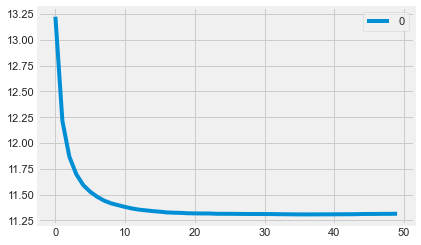

In [80]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val)
#elbow plot
curve.plot()

In [25]:
#%% Train: KNN
# selecting the k value = 20
def train_knn(X_t,y_t):
    
    knn = neighbors.KNeighborsRegressor(n_neighbors=20)
    knn.fit(X_train,y_train)
    print("KNN training... Done.")
    
    return knn
knn = train_knn(X_t, y_t)

# # Its important to use binary mode 
# knnPickle = open('models/knn_model', 'wb') 
      
# # source, destination 
# pickle.dump(knn, knnPickle)  

# close the file
# knnPickle.close()

#print performance metrics
print_performance_metrics(knn,X_tst, y_tst,"KNN")




KNN training... Done.
***** Performance metrics of Model: KNN *****
rmse score:  11.318542869938256
r2 score:  0.8713201830679426
mean absolute error:  8.622301643835616
*******************************************************


In [27]:
test_set['knn_predictions'] = knn.predict(X_test)
test_set.head()

,sales,year,dayofweek,day^year,daily_avg,monthly_avg,xgb_predictions,knn_predictions
1461,19,0.0,1.493344,-7.549409,-1.152154,-1.462102,16.542448,15.50
1462,15,0.0,-1.501549,-5.752584,-1.478373,-1.462102,10.982952,10.90
1463,10,0.0,-1.002400,-4.845175,-1.382967,-1.462102,12.597610,11.35
1464,16,0.0,-0.503251,-4.262891,-1.346849,-1.462102,12.647338,12.80
1465,14,0.0,-0.004103,-3.844221,-1.288242,-1.462102,13.972856,13.15


In [84]:
from math import sqrt
pred = knn.predict(X_test)

#rmse
error=sqrt(mean_squared_error(y_test,pred))
print("rmse value for k=20:",error)
# the mean accuracy on the given test data and labels.

score = knn.score(X_test,y_test)
print("r squared error for k=20:",score)

rmse value for k=20: 11.318542869938256
r squared error for k=20: 0.8713201830679426


## Training XGBOOST regressor


|metric       |Values      |
|----------------------|:-----------|
|R-squared score|0.8865168138655003|
|RMSE|10.629211853553358|
|mean absolute error|8.084572014239063|


- features: 'year', 'dayofweek', 'day^year', 'daily_avg', 'monthly_avg'


In [14]:
xgb_reg= xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
xgb_reg.fit(X_train, y_train, 
       eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
xgb_reg.save_model('models/xgb_reg.json')

In [28]:
xgb_reg= xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
#load model
xgb_reg.load_model('../models/xgb_reg.json')

In [29]:
#print performance metrics
print_performance_metrics(xgb_reg,X_tst, y_tst,"XGBoost")

***** Performance metrics of Model: XGBoost *****
rmse score:  10.629211853263762
r2 score:  0.8865168138655003
mean absolute error:  8.084572014239063
*******************************************************


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

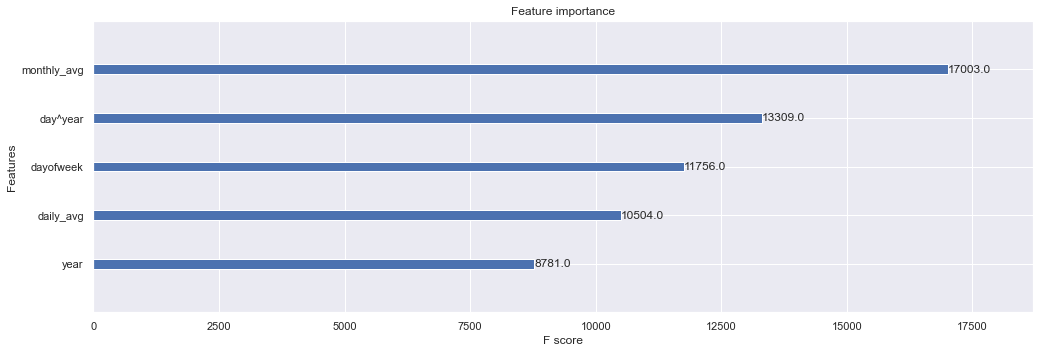

In [16]:
from xgboost import plot_importance
plot_importance(xgb_reg)

In [17]:
# confusion matrix R-squared score

xgb_reg.score(X_test,y_test)

0.8865168138655003

In [18]:
#rmse
xgb_reg.best_score

10.629211853553358

In [19]:
test_set['xgb_predictions'] = xgb_reg.predict(X_test)
test_set.head()

,sales,year,dayofweek,day^year,daily_avg,monthly_avg,xgb_predictions
1461,19,0.0,1.493344,-7.549409,-1.152154,-1.462102,16.542448
1462,15,0.0,-1.501549,-5.752584,-1.478373,-1.462102,10.982952
1463,10,0.0,-1.002400,-4.845175,-1.382967,-1.462102,12.597610
1464,16,0.0,-0.503251,-4.262891,-1.346849,-1.462102,12.647338
1465,14,0.0,-0.004103,-3.844221,-1.288242,-1.462102,13.972856


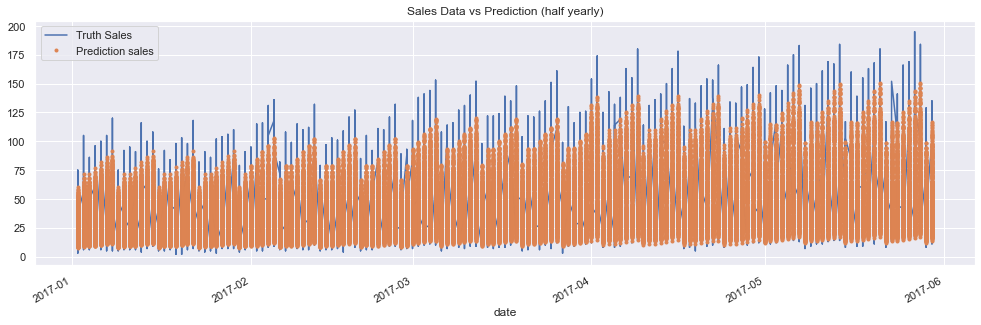

In [20]:
# train_set=data.loc[data['date'] < '2017-01-01']
# test_set=data.loc[data['date'] >= '2017-01-01']
df = data.copy()
df = df.merge(test_set[['xgb_predictions']],how='left',left_index=True,right_index=True)
df = df.set_index('date')

ax = df.loc[(df.index >'2017-01-01') & (df.index < '2017-05-31')]['sales'].plot(figsize=(15,5), title='Sales Data vs Prediction (half yearly)')
df.loc[(df.index >'2017-01-01') & (df.index < '2017-05-31')]['xgb_predictions'].plot(style='.')

plt.legend(['Truth Sales', 'Prediction sales'])

plt.show()


## XAI : SHAP

In [10]:
#xgboost
xgb_reg= xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
xgb_reg.load_model('models/xgb_reg.json')

#knn
knn = pickle.load(open('models/knn_model', 'rb'))

#random forest
model_rf = joblib.load("models/random_forest.joblib")

#lr
lr = pickle.load(open('models/lr_model.sav', 'rb'))




### XAI-----> RANDOM FOREST


In [14]:
import shap

In [15]:
X_t.columns

Index(['year', 'dayofweek', 'day^year', 'daily_avg', 'monthly_avg'], dtype='object')

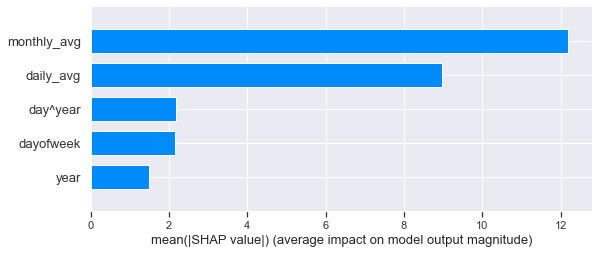

In [17]:
explainer_rf= shap.TreeExplainer(model_rf)
shap_values = explainer_rf.shap_values(X_t)
shap.summary_plot(shap_values, X_t, feature_names=X_t.columns,plot_type='bar')

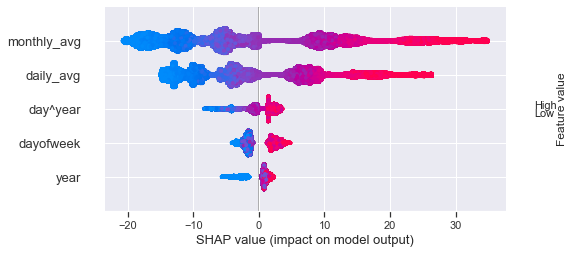

In [18]:
shap.summary_plot(shap_values,X_t)

### XAI-----> lr


Exact explainer: 182501it [21:27, 141.20it/s]                            


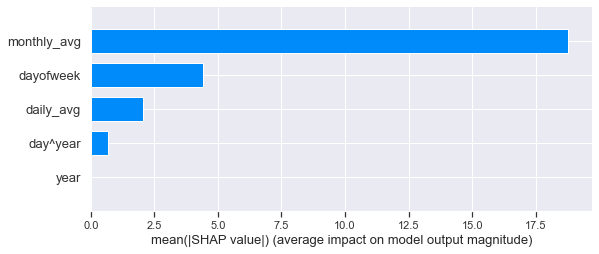

In [26]:
# X_t = X_train.copy()
# y_t = y_train.copy()

# X_tst = X_test.copy()
# y_tst = y_test.copy()


explainer_lr= shap.Explainer(lr.predict,X_tst)
shap_values = explainer_lr(X_tst)
shap.summary_plot(shap_values, X_t, feature_names=X_t.columns,plot_type='bar')

### XAI-----> knn

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names


  0%|          | 0/2000 [00:00<?, ?it/s]

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

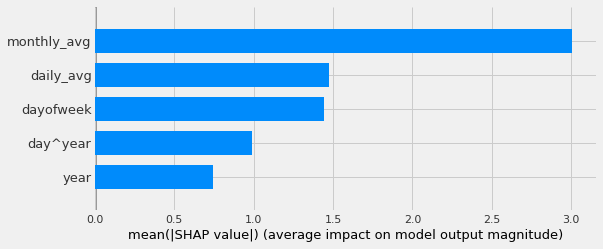

In [15]:
import shap
X_t = X_train.copy()
y_t = y_train.copy()

X_tst = X_test.copy()
y_tst = y_test.copy()
"""Must use Kernel method on KNN.
    Rather than use the whole training set to estimate expected values, we summarize with
    a set of weighted kmeans, each weighted by the number of points they represent.
    Running without the kmeans took 1 hr 6 mins 7 sec.
    Running with the kmeans took 2 min 47 sec.
    Boston Housing is a very small dataset.
    Running SHAP on models that require Kernel method and have a good amount of data becomes prohibitive"""
X_train_summary = shap.kmeans(X_t[:2000], 10)
# using kmeans

explainerKNN = shap.KernelExplainer(knn.predict, X_train_summary)
shap_values_KNN_test = explainerKNN.shap_values(X_tst[:2000])


shap.summary_plot(shap_values_KNN_test, X_t, feature_names=X_t.columns,plot_type='bar')



### xai ------>xgb


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


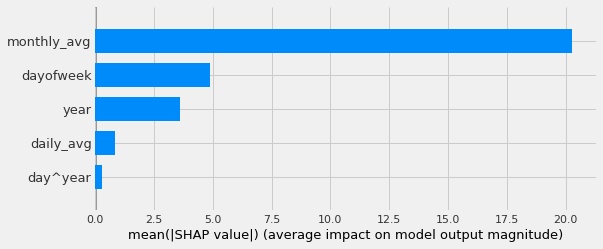

In [16]:
explainer_xgb = shap.TreeExplainer(xgb_reg)
shap_values = explainer_xgb.shap_values(X_t)
shap.summary_plot(shap_values, X_t, feature_names=X_t.columns,plot_type='bar')

### Summary

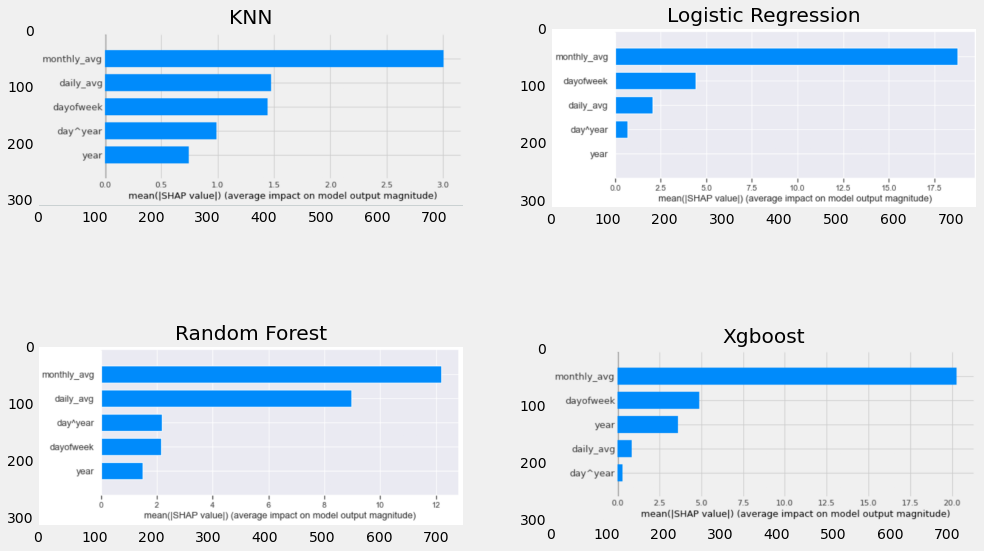

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



img1 = mpimg.imread('figures/xai_knn.png')
img2 = mpimg.imread('figures/xai_lr.png')
img3 = mpimg.imread('figures/xai_rf.png')
img4 = mpimg.imread('figures/xai_xgb.png')

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(221)
plt.imshow(img1)
ax2 = fig.add_subplot(222)
plt.imshow(img2)
ax3 = fig.add_subplot(223)
plt.imshow(img3)
ax4 = fig.add_subplot(224)
plt.imshow(img4)
ax1.title.set_text('KNN')
ax2.title.set_text('Logistic Regression')
ax3.title.set_text('Random Forest')
ax4.title.set_text('Xgboost')

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax4.grid(False)

plt.savefig('xai_comparison.png')
plt.show()